# Automatic function-level dependency tracking
`mandala` is heavily based on memoization. However, memoization assumes that the
meaning of a function does not change over time (which justifies storing the
results of a past call). This is not always the case! 

In the previous tutorial, you saw how to manually mark a function as changed by
creating a new version of it. Sometimes, this can be tedious and error-prone. In
this tutorial, you'll use **automatic dependency tracking** to detect when the
meaning of a memoized function has (potentially) changed, and choose how to
respond - whether to make a new version on any change, ignore changes, or
manually inspect the dependency diff and decide what to do on a case-by-case
basis.

This doesn't require any special syntax or annotations beyond labeling functions
with what you want to do when a change is detected. It "just works" for most
common use cases, raises exceptions when it detects a dependency it can't track,
and tracks changes in individual functions, methods, and global variables, as
opposed to the level of entire modules or classes.

## Understanding dependencies
To get started, let's define a memoized function that depends on a few different 
things: a helper function, a global variable, and a class method:

In [1]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from mandala_lite.imports import *
from typing import Tuple
from pathlib import Path

N_SAMPLES = 1000
C = 0.1
X, y = make_classification(n_samples=N_SAMPLES, random_state=42)

def split_data(X, y, test_size):
    from sklearn.model_selection import train_test_split
    return train_test_split(X, y, test_size=test_size, random_state=42)


class MyRegression: # a thin wrapper around sklearn's LogisticRegression
    def __init__(self):
        self.lr = LogisticRegression(C=C)
    
    def fit(self, X, y):
        self.lr.fit(X, y)
    
    def score(self, X, y):
        return self.lr.score(X, y)

@op
def train_model(test_size: float) -> float:
    X_train, X_test, y_train, y_test = split_data(X, y, test_size=test_size)
    model = MyRegression()
    model.fit(X_train, y_train)
    acc = model.score(X_test, y_test)
    return acc

/home/amakelov/workspace/current/conda_envs/mandala_lite_3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


It helps to understand a few things about the space of possible
dependencies a function can have:
- in general, a function's dependencies (ignoring the Python runtime itself)
include:
  - the function's own source code;
  - the global variables that it accesses;
  - recursively, the dependencies of any functions/methods that it calls.

  In the above example, we see instances of all three. 
- by tracking the dependencies, and changes in them over time, you can detect
  when a memoized function's result is "stale". Note that whether or not a
  result is stale depends on the function's dependencies **for a particular
  call**. 
- global variable dependencies can be interesting: the `X, y` global variables
used by `train_model` are not your "typical" scalar global variables. They are
in fact arrays, which in turn are computed using other global variables!

## Tracking dependencies
`mandala` offers a way to automatically approximate the dependencies of a
function, and detect when they *may* have changed. Let's see how it works.

### The `deps_root` setting
First, let's create a storage, and examine the dependencies of `train_model`. By
default, storages don't track dependencies; if you want to enable this, you have
to provide a path for the `deps_root` argument. Any code you want to track must
be contained in this directory. In our case, we simply use the current directory
of this notebook:

In [2]:
NOTEBOOK_DIR = Path().resolve()
storage = Storage(deps_root=NOTEBOOK_DIR)
storage.synchronize(train_model) # syncs the function to the storage without running it yet
storage.get_deps(train_model)

Empty DependencyState object

As you can see, there are no dependencies. This is because **function
dependencies are only collected during calls to the function**. So, let's call
`train_model` and visualize the collected dependencies:

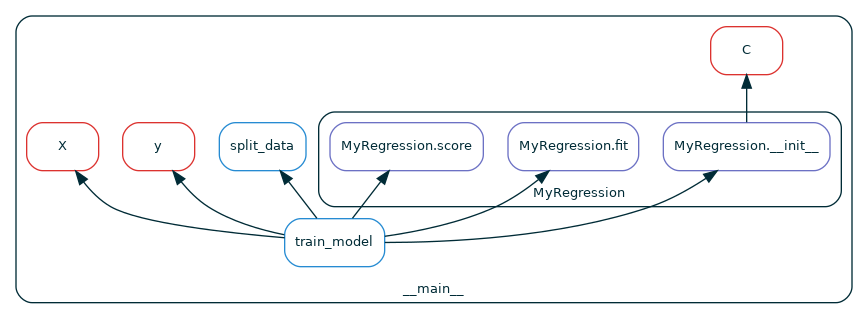

In [3]:
with storage.run():
    acc = train_model(test_size=0.2)

deps = storage.get_deps(train_model)
deps.show(how='inline')

This graph is read as follows:
- **bounding boxes** delineate modules (`__main__` is the name of the module in a
  Jupyter notebook) and classes;
- **arrows** represent *immediate* dependencies from a function to a function or
  global variable;
- **red** nodes represent global variables, **blue** nodes represent functions, and
  **purple** nodes represent methods.

## Detecting changes
Now to the fun part: automatically reacting to changes in dependencies. **To make
a memoized function react to changes in its dependencies**, you have to provide
the `on_change` argument to the `@op` decorator, and put the function definition
in a `with storage.define()` block. For now, we'll just copy over the definition
of `train_model` and set `on_change` to the builtin value `OnChange.ask`, which
will explicitly ask you what to do when a change is detected:

In [4]:
with storage.define():
    
    @op(on_change=OnChange.ask)
    def train_model(test_size: float) -> float:
        X_train, X_test, y_train, y_test = split_data(X, y, test_size=test_size)
        model = MyRegression()
        model.fit(X_train, y_train)
        acc = model.score(X_test, y_test)
        return acc

Now, let's make three different kinds of changes to the dependencies:
- change one of the constants used to compute `X`;
- change the body of the method `__init__` of the `MyRegression` class.
- change the body of `train_model` itself;

As you'll see when you run the below, you'll be presented with a diff of the
dependencies, organized by module and the kind of dependency (function or global
variable), and asked what to do. Let's choose to create a new version of the
function:

In [5]:
N_SAMPLES = 10_000 # CHANGE: value of a global variable
X, y = make_classification(n_samples=N_SAMPLES, random_state=42)

class MyRegression: 
    def __init__(self):
        self.lr = LogisticRegression(C=C, penalty='none') # CHANGE: penalty to 'none' 
    
    def fit(self, X, y):
        self.lr.fit(X, y)
    
    def score(self, X, y):
        return self.lr.score(X, y)

with storage.define():
    
    @op(on_change=OnChange.ask)
    def train_model(test_size: float) -> float:
        X_train, X_test, y_train, y_test = split_data(X, y, test_size=test_size)
        model = MyRegression()
        model.fit(X_train, y_train)
        acc = model.score(X_test, y_test)
        print(f'accuracy: {acc}') # CHANGE: print the accuracy
        return acc

Detected changes in the dependencies of train_model:
    ===THE FOLLOWING DEPENDENCIES HAVE CHANGED===
    MODULE __main__:
        ===GLOBALS===:
            X: 
            -array([[-0.6693561 , -1.49577819, -0.87076638, ..., -1.26733697, [...]
            +array([[-0.6531912 , -0.81238767, 1.19535267, ..., 1.60033929, 0.77295496, [...]
            y: 
            -array([1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, [...]
            +array([1, 1, 1, ..., 0, 1, 1])
        ===FUNCTIONS===:
            <<<train_model>>>:
                -@op
                -def train_model(test_size: float) -> float:
                -    X_train, X_test, y_train, y_test = split_data(X, y, test_size=test_size)
                -    model = MyRegression()
                -    model.fit(X_train, y_train)
                -    acc = model.score(X_test, y_test)
                -    return acc
                +    @op(on_change=OnChange.ask)
                +    def train_model(test_size

To verify that you are now using the new version of the function, confirm that
`version=1` is printed out:

In [6]:
train_model

FuncInterface(func_name=train_model, version=1, on_change=ask, autoversion=False)

You can further confirm this by running the function again, and seeing that the
message gets printed out!

In [7]:
with storage.run():
    train_model(test_size=0.2)

accuracy: 0.8945


/home/amakelov/workspace/current/conda_envs/mandala_lite_3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


## Other options for `on_change`
By using `OnChange.new_version`, we would get the same effect on any detected
change automatically (without being asked). As another example, let's remove the 
`print` statement from the body of `train_model`, while using
`OnChange.overwrite` to update the dependencies without creating a new version:

In [8]:
with storage.define():
    
    @op(on_change=OnChange.overwrite)
    def train_model(test_size: float) -> float:
        X_train, X_test, y_train, y_test = split_data(X, y, test_size=test_size)
        model = MyRegression()
        model.fit(X_train, y_train)
        acc = model.score(X_test, y_test)
        return acc

Overwrote the dependencies of train_model with the new state.


Again, you can confirm this by printing the function (which should still be at
`version=1`), and examining the dependencies to see that the `print` statement
is gone:

In [9]:
train_model

FuncInterface(func_name=train_model, version=1, on_change=overwrite, autoversion=False)

In [10]:
storage.get_deps(train_model)

MODULE __main__:
    ===GLOBALS===:
        X: array([[-0.6531912 , -0.81238767, 1.19535267, ..., 1.60033929, 0.77295496, [...]
        y: array([1, 1, 1, ..., 0, 1, 1])
        C: 0.1
    ===FUNCTIONS===:
        <<<train_model>>>:
            @op(on_change=OnChange.overwrite)
            def train_model(test_size: float) -> float:
                X_train, X_test, y_train, y_test = split_data(X, y, test_size=test_size)
                model = MyRegression()
                model.fit(X_train, y_train)
                acc = model.score(X_test, y_test)
                return acc
        <<<split_data>>>:
            def split_data(X, y, test_size):
                from sklearn.model_selection import train_test_split
                return train_test_split(X, y, test_size=test_size, random_state=42)
        <<<MyRegression.__init__>>>:
            def __init__(self):
                self.lr = LogisticRegression(C=C, penalty='none') # CHANGE: penalty to 'none' 
        <<<MyRegression.fit>